In [7]:
import os 
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms

In [12]:
import os 
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
# import insight_face
from insightface.app import FaceAnalysis
import paho.mqtt.client as mqtt
import time
import shutil

In [13]:
model = FaceAnalysis(providers=['CPUExecutionProvider'])
model.prepare(ctx_id = -1)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\cuctr/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\cuctr/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\cuctr/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\cuctr/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\cuctr/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

In [16]:
data_dir =  r'D:\Document\IOT\nhandienkhuonmat-20230626T162738Z-001\nhandienkhuonmat\Dataset\FaceData\processed\thinh'
embeddings = []
names = []
for name in os.listdir(data_dir):
    name_dir = os.path.join(data_dir, name)
    print(name_dir)
    if not os.path.isdir(name_dir):
        continue
    for image_file in os.listdir(name_dir):
        image_path = os.path.join(name_dir, image_file)
        print(image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        face = model.get(img)[0]
        embedding = face.embedding
        embeddings.append(embedding)
        print(embedding)
        names.append(name)

embeddings = np.array(embeddings)
names = np.array(names)

print(embeddings.shape)
print(names.shape)

D:\Document\IOT\nhandienkhuonmat-20230626T162738Z-001\nhandienkhuonmat\Dataset\FaceData\processed\thinh\thinh_image_1.png
D:\Document\IOT\nhandienkhuonmat-20230626T162738Z-001\nhandienkhuonmat\Dataset\FaceData\processed\thinh\thinh_image_2.png
D:\Document\IOT\nhandienkhuonmat-20230626T162738Z-001\nhandienkhuonmat\Dataset\FaceData\processed\thinh\thinh_image_3.png
D:\Document\IOT\nhandienkhuonmat-20230626T162738Z-001\nhandienkhuonmat\Dataset\FaceData\processed\thinh\thinh_image_4.png
(0,)
(0,)


In [17]:

# Lưu trữ nhúng khuôn mặt và nhãn vào các tệp
np.save('face_embeddings.npy', embeddings)
np.save('face_labels.npy', names)

[[0.70491445 0.8001228  0.7815791  0.35256112 0.25626755 0.2457611
  0.24622571 0.7465604  0.7657267  0.8341663  0.7398286 ]]
label:  thinh
distance:  0.2457611


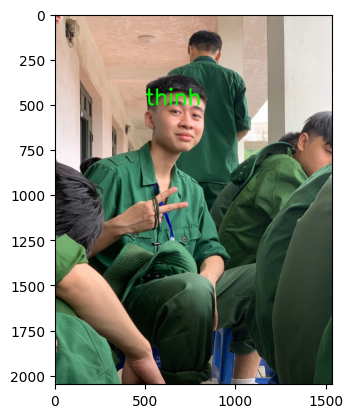

In [6]:
import matplotlib.pyplot as plt
# Tải nhúng khuôn mặt và nhãn từ các tệp đã lưu
embeddings = np.load('face_embeddings.npy')
labels = np.load('face_labels.npy')
threshold = 0.5
# Hàm nhận diện khuôn mặt
def recognize_face(image, embeddings, labels):
    # Phát hiện khuôn mặt trong hình ảnh đầu vào
    faces = model.get(image)
    if faces is not None and len(faces) > 0:
        # Tính toán nhúng khuôn mặt cho các khuôn mặt phát hiện được
        face_embeddings = [face.embedding for face in faces]
        dot_product = np.dot(face_embeddings, embeddings.T)
        norm_face = np.linalg.norm(face_embeddings, axis=1, keepdims=True)
        norm_db = np.linalg.norm(embeddings, axis=1, keepdims=True)
        similarity = dot_product / (norm_face * norm_db.T)
        # print(similarity)
        cosine_distance = 1 - similarity
        print(cosine_distance)
        distances = np.squeeze(cosine_distance)
        # print(distances)
        # Tìm vị trí của nhúng khuôn mặt gần nhất
        min_distance_idx = np.argmin(distances)
        min_distance = distances[min_distance_idx]
        label = labels[min_distance_idx]
        # Xác định nhãn tương ứng
        # if min_distance < threshold:
            # label = labels[min_distance_idx]
        return label, min_distance
        # else:
        #     return "Unknown", min_distance
    else:
        return "No face detected", None
# Đọc hình ảnh đầu vào
image_path = r'D:\document\IOT\thinhngu.jpg'
image = cv2.imread(image_path)
# write text on image
# Gọi hàm nhận diện khuôn mặt
label, distance = recognize_face(image)
print('label: ', label)
print('distance: ', distance)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(image, str(label), (500, 500), font, 4, (0, 255, 0), 10, cv2.LINE_AA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
# Hiển thị kết quả


In [7]:
# import matplotlib.pyplot as plt
# import cv2
# cap = cv2.VideoCapture(0)
# PATH = 'D:/document/IOT/Face_bank'
# text = input('Enter your name: ')
# count = 0
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     # create folder for every person
#     if not os.path.exists(os.path.join(PATH, text)):                    
#         os.mkdir(os.path.join(PATH, text))
#     image_path = os.path.join(PATH, text, str(count) + '.jpg')
#     cv2.imwrite(image_path, frame)
#     recognize_face(frame)
#     # count += 1
#     # if count == 10:
#     #     break
# cap.release()


In [8]:
def update_user(user_name):
    cap = cv2.VideoCapture(0)
    PATH = 'D:/document/IOT/Face_bank'
    text = user_name.replace('"', '').replace("}", '')
    print('User name: ', text) 
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # create folder for every person
        if not os.path.exists(os.path.join(PATH, text)):                    
            os.mkdir(os.path.join(PATH, text))
        image_path = os.path.join(PATH, text, str(count) + '.jpg')
        cv2.imwrite(image_path, frame)
        count += 1
        if count == 5:
            cap.release()
            break

In [9]:
def check_user_from_webcam():
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if 0xff == ord('D'):
            label, distance = recognize_face(frame)
            print('label: ', label)
            print('distance: ', distance)
        break
    cap.release()
    # return label

In [10]:
import paho.mqtt.client as mqtt
import time

broker_add = "hungviet.hopto.org"
port = 1883
client_ID = 'device_1'
username = 'vikings'
password = '19013005'
client = mqtt.Client(client_ID)
client.username_pw_set(username, password)
client.connect(broker_add, port=port)
string = str(check_user_from_webcam())
print(string)
# if string.find('None') != -1:
client.publish("kookdump", string)



None


In [12]:
import cv2
import os
def is_q_pressed():
    # Check if the 'q' key is pressed
    return cv2.waitKey(1) & 0xFF == ord('q')
def is_a_pressed():
    # Check if the 'a' key is pressed
    return cv2.waitKey(1) & 0xFF == ord('a')

def add_face(text):
    cap = cv2.VideoCapture(0)
    count = 0
    PATH = 'D:/document/IOT/Face_bank'
    print('name:', text)   
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            # create folder for every person
        if not os.path.exists(os.path.join(PATH, text)):                    
            os.mkdir(os.path.join(PATH, text))
            cv2.imshow('frame', frame)
            print('Press "a" to add face')
        if is_a_pressed():
            image_path = os.path.join(PATH, text, str(count) + '.jpg')
            cv2.imwrite(image_path, frame)
            count += 1
        if count == 5 or is_q_pressed():
            cap.release()
            break

In [13]:
import paho.mqtt.client as mqtt
import time

# Cài đặt thông tin kết nối MQTT
broker_address = "hungviet.hopto.org"  # Thay thế bằng địa chỉ broker MQTT của bạn
broker_port = 1883  # Thay thế bằng cổng của broker MQTT của bạn
topic_pub = "koodump"
topic_sub = "kook"
username = "vikings"  # Thay thế bằng tên người dùng của bạn
password = "19013005"  # Thay thế bằng mật khẩu của bạn

# Hàm callback khi kết nối MQTT thành công
def on_connect(client, userdata, flags, rc):
    print("Connected with result code " + str(rc))
    # Khi kết nối thành công, đăng ký để subscribe vào topic_sub
    client.subscribe(topic_sub)
# Hàm callback khi nhận được message từ broker
def on_message(client, userdata, msg):
    options =  str(msg.payload.decode("utf-8"))
    print(options)
    option, user_name = options.split(":")
    if option == 'ADD':
        add_face(user_name)
# Khởi tạo client MQTT
client = mqtt.Client()
# Thiết lập thông tin đăng nhập
client.username_pw_set(username, password)
# Thiết lập các hàm callback
client.on_connect = on_connect
client.on_message = on_message
# Kết nối đến broker MQTT
client.connect(broker_address, broker_port, 60)
client.loop_start()
i = 0
try:
    while True:
        i = i+1
        # Gửi một message lên broker MQTT
        message = "Hello, this is a published message. " + f"{i}"
        client.publish(topic_pub, message)
        # print("Published message: " + message)
        # Đợi 1 giây trước khi gửi message tiếp theo
        time.sleep(1)
except KeyboardInterrupt:
    # Ngắt kết nối và thoát chương trình khi nhấn Ctrl+C
    client.loop_stop()
    client.disconnect()
    print("Disconnected from broker.")


Connected with result code 0
ADD:cook
name: cook
Press "a" to add face


In [1]:
path = r'face_labels.npy'
import numpy as np
labels = np.load(path)
print(labels)

['quoc' 'quoc' 'quoc' 'thinh' 'thinh' 'thinh' 'thinh' 'kook' 'kook' 'kook'
 'kook' 'kook' 'kook' 'kook' 'kook' 'kook' 'kook' 'viet' 'viet' 'viet'
 'viet' 'viet' 'viet' 'viet' 'viet' 'viet' 'viet' 'Viet' 'Viet' 'Viet'
 'Viet' 'Viet' 'Viet' 'Viet' 'Viet' 'Viet' 'Viet' 'viet' 'viet' 'viet'
 'viet' 'viet' 'viet' 'viet' 'viet' 'viet' 'viet']


In [2]:
face = r'face_embeddings.npy'
face = np.load(face)
np.delete(face,axis = 0)

[[-2.3347199e-02  2.6290507e+00 -1.0899553e+00 ...  1.6699135e-01
  -4.0919492e-01  6.6942751e-01]
 [-2.3164111e-01  2.0966663e+00 -5.8274639e-01 ...  1.9502777e-01
  -3.1986466e-01  1.2349597e+00]
 [ 5.3622916e-02  2.6863995e+00 -1.6757510e+00 ... -1.5220996e+00
   7.6132083e-01  1.2879912e+00]
 ...
 [-2.9211932e-01 -6.8766594e-02 -2.6619163e+00 ... -9.9134803e-01
   2.2578257e-01  4.0887915e-02]
 [-5.1497436e-01  2.5982559e-03 -2.0302155e+00 ... -1.5898876e+00
   6.6258860e-01 -2.1396281e-01]
 [-5.1444262e-01 -2.4513204e-01 -2.1705804e+00 ... -1.2613922e+00
   6.2677914e-01  1.2272869e-01]]
